In [2]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["mathtext.default"] = "regular"
path_to_results = Path("../../../results/rates")

In [21]:
## From https://www.engineeringtoolbox.com/standard-atmosphere-d_604.html
# Geopotential altitude above sea level [km]
height = (
    np.array(
        [
            0,
            1000,
            2000,
            3000,
            4000,
            5000,
            6000,
            7000,
            8000,
            9000,
            10000,
            15000,
            20000,
            25000,
            30000,
            40000,
            50000,
            60000,
            70000,
            80000,
        ]
    )
    * 1e-3
)
# Air temperature [K]
temp = (
    np.array(
        [
            15.00,
            8.50,
            2.00,
            -4.49,
            -10.98,
            -17.47,
            -23.96,
            -30.45,
            -36.94,
            -43.42,
            -49.90,
            -56.50,
            -56.50,
            -51.60,
            -46.64,
            -22.80,
            -2.5,
            -26.13,
            -53.57,
            -74.51,
        ]
    )
    + 273.15
)
# Acceleration due to gravity [m s-2]
g = np.array(
    [
        9.807,
        9.804,
        9.801,
        9.797,
        9.794,
        9.791,
        9.788,
        9.785,
        9.782,
        9.779,
        9.776,
        9.761,
        9.745,
        9.730,
        9.715,
        9.684,
        9.654,
        9.624,
        9.594,
        9.564,
    ]
)
# Absolute air pressure [Pa]
pres = (
    np.array(
        [
            10.13,
            8.988,
            7.950,
            7.012,
            6.166,
            5.405,
            4.722,
            4.111,
            3.565,
            3.080,
            2.650,
            1.211,
            0.5529,
            0.2549,
            0.1197,
            0.0287,
            0.007978,
            0.002196,
            0.00052,
            0.00011,
        ]
    )
    * 1e4
)
# Air density [kg m-3]
rho = np.array(
    [
        1.225,
        1.112,
        1.007,
        0.9093,
        0.8194,
        0.7364,
        0.6601,
        0.5900,
        0.5258,
        0.4671,
        0.4135,
        0.1948,
        0.08891,
        0.04008,
        0.01841,
        0.003996,
        0.001027,
        0.0003097,
        0.00008283,
        0.00001846,
    ]
)
# Dynamic viscosity [10e-5 N s m-2]
mu = np.array(
    [
        1.789,
        1.758,
        1.726,
        1.694,
        1.661,
        1.628,
        1.595,
        1.561,
        1.527,
        1.493,
        1.458,
        1.422,
        1.422,
        1.448,
        1.475,
        1.601,
        1.704,
        1.584,
        1.438,
        1.321,
    ]
)

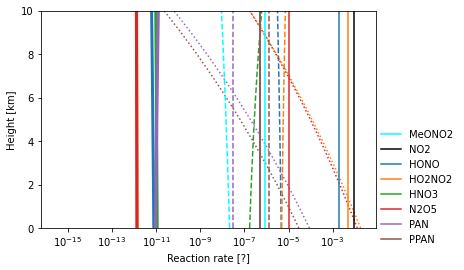

In [171]:
fig, ax = plt.subplots()

ax.plot(
    np.array(
        [
            m_oh_no(T, M)
            for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])
        ]
    ),
#     * nd_oh,
    height,
    color="C0",
    linestyle="solid",
    linewidth=3,
)
ax.plot(
    np.array(
        [
            m_ho2_no2(T, M)
            for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])
        ]
    ),
    height,
    color="C1",
    linestyle="solid",
    linewidth=3,
)

ax.plot(
    np.array(
        [m_oh_no2(T, M) for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])]
    ),
    height,
    color="C2",
    linestyle="solid",
    linewidth=3,
)
ax.plot(
    np.array(
        [m_no2_no3(T, M) for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])]
    ),
    height,
    color="C3",
    linestyle="solid",
    linewidth=3,
)
ax.plot(
    np.array(
        [m_meco3_no2(T, M) for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])]
    ),
    height,
    color="C4",
    linestyle="solid",
    linewidth=3,
)

nd_oh = 1e6
ax.plot(np.array([k_oh_hono(T) for T in temp]) * nd_oh, height, color="C0", linestyle="dashed")
ax.plot(np.array([k_oh_ho2no2(T) for T in temp]) * nd_oh, height, color="C1", linestyle="dashed")
ax.plot(
    np.array(
        [
            k_oh_hno3(T, M)
            for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])
        ]
    )
    * nd_oh,
    height,
    color="C2",
    linestyle="dashed",
)
ax.axvline(x=k_oh_pan * nd_oh, color="C4", linestyle="dashed")
ax.axvline(x=k_oh_ppan * nd_oh, color="C5", linestyle="dashed")

ax.plot(
    [
        m_ho2no2(T, M)
        for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])
    ],
    height,
    color="C1",
    linestyle="dotted",
)
ax.plot(
    [
        m_n2o5(T, M)
        for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])
    ],
    height,
    color="C3",
    linestyle="dotted",
)
ax.plot(
    [
        m_pan(T, M)
        for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])
    ],
    height,
    color="C4",
    linestyle="dotted",
)
ax.plot(
    [
        m_ppan(T, M)
        for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])
    ],
    height,
    color="C5",
    linestyle="dotted",
)

ax.axvline(x=k_meono2_hv, color="cyan", label="MeONO2")
ax.plot(np.array([k_oh_meono2(T) for T in temp])*nd_oh, height, color="cyan", linestyle="dashed")

ax.set_xlabel("Reaction rate [?]")
ax.set_xscale("log")
ax.set_ylabel("Height [km]")
ax.set_ylim(0, 10)

# ax2 = ax.twiny()
# ax2.plot(temp, height)
# ax2.set_xlabel("Temperature [K]")

# ax3 = ax.twinx()
# ax3.plot(temp, pres, alpha=0)
# ax3.set_ylabel("Pressure [Pa]")
# ax3.set_yscale("log")
# ax3.invert_yaxis()

ax.axvline(x=k_no2_hv, color="k", label="NO2")
ax.axvline(x=k_hono_hv, color="C0", label="HONO")
ax.axvline(x=k_ho2no2_hv, color="C1", label="HO2NO2")
ax.axvline(x=k_hno3_hv, color="C2", label="HNO3")  # similar to PAN+hv
ax.axvline(x=k_n2o5_hv, color="C3", label="N2O5")
ax.axvline(x=k_pan_hv, color="C4", label="PAN")
ax.axvline(x=k_ppan_hv, color="C5", label="PPAN")
fig.legend(frameon=False, bbox_to_anchor=(1.1, 0.5));

In [126]:
def calc_air_number_density(air_pressure, air_temperature):
    """Calculate air number density M as a function of temperature and pressure"""
    V = 1  # [m3] 10**6 cm3
    avogadro_const = 6.022 * 1e23  # [mol-1]
    gas_const = 8.314  # [J K-1 mol-1]
    nd_air = air_pressure * V / (gas_const * air_temperature * 1e6) * avogadro_const
    return nd_air


def J(l, m, n):
    X = np.deg2rad(45)  # 45N
    J = l * (np.cos(X) ** m) * np.exp(-n * np.arccos(X))
    return J

def k3rd_order(T, M, Fc, klow, alpha_low, beta_low, khigh, alpha_high, beta_high):
    '''Function for CheT generic rate coefficients (from Paul's .def footer)'''
    k_low = klow * (T/300.)**(alpha_low) * np.exp(-beta_low/T) * M
    k_high = khigh * (T/300.)**(alpha_high) * np.exp(-beta_high/T)
    if Fc < 0.1:
        k3rd_order = k_low
    else:
        if Fc > 1.0:
            zfc = np.exp(-T/Fc)
        else:
            zfc=Fc
        zo = k_low
        zi = k_high
        zr = zo / zi
        k3rd_order = (zo/(1.0 + zr)) * zfc**(1.0/(1.0 + (np.log10(zr))**2.))
    return k3rd_order

In [154]:
k_hno3_hv

4.953572382027121e-07

In [165]:
k_no2_hv = J(1.165e-02, 0.244, 0.267)  # [s-1] J4 MCM v3.3.1

k_hono_hv = J(2.644e-03, 0.261, 0.288)  # [s-1] J7 MCM v3.3.1 http://mcm.york.ac.uk/inorg2.htt

k_ho2no2_hv = 5e-3  # [s-1] from http://cires1.colorado.edu/jimenez/AtmChem/CHEM-5151_S05_L7.pdf

k_hno3_hv = J(9.312e-07, 1.230, 0.307)  # [s-1] J8 MCM v3.3.1

k_n2o5_hv = 1e-5  # [s-1] from http://cires1.colorado.edu/jimenez/AtmChem/CHEM-5151_S05_L7.pdf

k_pan_hv = 5e-7

k_ppan_hv = 5e-7

k_meono2_hv = J(1.588e-06,1.154,0.318) # J51 MCM v3.3.1


def k_oh_hono(T):
    """OH+HONO=H2O+NO2
    JPL2015 (new):        1.8e-11*exp(-390/T) over the temperature range 278-1400 K
    """
    y = 1.8e-11 * np.exp(-390 / T)
    return y


def k_oh_ho2no2(T):
    """OH+HO2NO2=H2O+NO2+O2
    JPL2015 (new):   1.30e-12*exp(380/T) over the temperature range 218-335 K
    """
    y = 1.30e-12 * np.exp(380 / T)
    return y


def k_oh_hno3(T, M):
    """OH+HNO3=H2O+NO3
    IUPAC2004/7 (old)
    """
    k1 = 2.4e-14 * np.exp(460 / T)  # [cm3 molecule-1 s-1]
    k3 = 6.5e-34 * np.exp(1335 / T)  # [cm6 molecule-2 s-1]
    k4 = 2.7e-17 * np.exp(2199 / T)  # [cm3 molecule-1 s-1]
    k2 = k3 * M / (1 + k3 * M / k4)
    y = k1 + k2
    return y


# N2O5+OH reaction doesn't exist in gerenal

# OH+PAN=HCHO+NO2+H2O+CO MCMv3.2/v3.3.1
k_oh_pan = 3.00e-14
# OH+PPAN=MeCHO+NO2+H2O+CO MCMv3.2/v3.3.1
k_oh_ppan = 1.27e-12


# HONO doesn't thermally decompose


def m_ho2no2(T, M):
    """HO2NO2+M=HO2+NO2
    MCMv3.3.1 KMT10
    """
    K100 = 4.10e-05 * M * np.exp(-10650 / T)
    K10I = 6.0e15 * np.exp(-11170 / T)
    KR10 = K100 / K10I
    FC10 = 0.4
    NC10 = 0.75 - 1.27 * (np.log10(FC10))
    F10 = 10 ** (np.log10(FC10) / (1 + (np.log10(KR10) / NC10) ** 2))
    KMT10 = (K100 * K10I) * F10 / (K100 + K10I)
    return KMT10


# HNO3 doesn't thermally decompose


def m_n2o5(T, M):
    """N2O5+M=NO2+NO3
    MCMv3.3.1 KMT04
    """
    K40 = 1.3e-3 * M * (T / 300) ** (-3.5) * np.exp(-11000 / T)
    K4I = 9.7e14 * (T / 300) ** (0.1) * np.exp(-11080 / T)
    KR4 = K40 / K4I
    FC4 = 0.35
    NC4 = 0.75 - 1.27 * (np.log10(FC4))
    F4 = 10 ** (np.log10(FC4) / (1 + (np.log10(KR4) / NC4) ** 2))
    KMT04 = (K40 * K4I) * F4 / (K40 + K4I)
    return KMT04


def m_pan(T, M):
    """PAN=CH3CO3+NO2
    MCMv3.3.1 KBPAN
    """
    KD0 = 1.1e-5 * M * np.exp(-10100 / T)
    KDI = 1.9e17 * np.exp(-14100 / T)
    KRD = KD0 / KDI
    FCD = 0.30
    NCD = 0.75 - 1.27 * (np.log10(FCD))
    FD = 10 ** (np.log10(FCD) / (1 + (np.log10(KRD) / NCD) ** 2))
    KBPAN = (KD0 * KDI) * FD / (KD0 + KDI)
    return KBPAN


def m_ppan(T, M):
    """PPN=C2H5CO3+NO2
    MCMv3.3.1 KBPPN
    """
    KPPN0 = 1.7e-3 * np.exp(-11280 / T) * M
    KPPNI = 8.3e16 * np.exp(-13940 / T)
    KRPPN = KPPN0 / KPPNI
    FCPPN = 0.36
    NCPPN = 0.75 - 1.27 * (np.log10(FCPPN))
    FPPN = 10 ** (np.log10(FCPPN) / (1 + (np.log10(KRPPN) / NCPPN) ** 2))
    KBPPN = (KPPN0 * KPPNI) * FCPPN / (KPPN0 + KPPNI)
    return KBPPN


def m_oh_no(T, M):
    """OH+NO+M=HONO+M
    JPL2011 (old): k3rd_order(T,M,0.6,7.00E-31,-2.60,0.00,3.60E-11,-0.10,0.00)
    """
    # ratt_t('OH        ','NO        ','HONO      ','m         ',     0.6,    & ! T013
    #   7.00E-31, -2.60,     0.00,  3.60E-11, -0.10,     0.00),               & ! T013 JPL 2011
    # ! T013 OH+NO -> HONO m JPL 2011
    # ! T013 IUPAC 2002 recommend k0 = 7.40E-31*(T/300)^-2.4 kinf =
    # ! T013 3.3E-11*(T/300)^-0.3 Fc = 0.81
    y = k3rd_order(T, M, 0.6, 7.00e-31, -2.60, 0.00, 3.60e-11, -0.10, 0.00)
    return y


def m_ho2_no2(T, M):
    """HO2+NO2=HO2NO2+M
    JPL2015 (new): k3rd_order(T,M,0.6,1.90E-31,-3.4,0.0,4.00E-12,-0.3,0.0), temperture range is unclear from documentation
    """
    y = k3rd_order(T, M, 0.6, 1.90e-31, -3.4, 0.0, 4.00e-12, -0.3, 0.0)
    return y


def m_oh_no2(T, M):
    """OH+NO2+M=HNO3+M
    JPL2011 (old): k3rd_order(T,M,0.6,1.80E-30,-3.00,0.00,2.80E-11,0.00,0.00)
    """
    y = k3rd_order(T,M,0.6,1.80E-30,-3.00,0.00,2.80E-11,0.00,0.00)
    return y


def m_no2_no3(T, M):
    """NO2+NO3+M=N2O5+M (Fc was originally 0.3 in UKCA)
    JPL2015 (new):   k3rd_order(T,M,0.60,2.4E-30,-3.0,0.0,1.60E-12,0.1,0.0) at 298 K
    """
    y = k3rd_order(T,M,0.60,2.4E-30,-3.0,0.0,1.60E-12,0.1,0.0)
    return y

def m_meco3_no2(T, M):
    """MeCO3+NO2+M=PAN+M and 20. EtCO3+NO2=PPAN+M
    IUPAC2014 (new): KFPAN over temperature range 250-300 K for low-pressure limit and 250-300 for high-pressure limit
    """
    KC0 = 3.28e-28*M*(T/300)**(-6.87)
    KCI = 1.125e-11*(T/300)**(-1.105)
    KRC = KC0/KCI
    FCC = 0.30
    NC = 0.75-1.27*(np.log10(FCC))
    FC = 10**(np.log10(FCC)/(1+(np.log10(KRC)/NC)**2))
    KFPAN = (KC0*KCI)*FC/(KC0+KCI)
    return KFPAN

def k_oh_meono2(T):
    "MCMv3.3.1"
    y = 4.0e-13 * np.exp(-845 / T)
    return y

In [147]:
[m_meco3_no2(T, M) for T, M in zip(temp, [calc_air_number_density(P, T) for P, T in zip(pres, temp)])]

[9.407767681302211e-12,
 9.665992622050565e-12,
 9.937194450459645e-12,
 1.0222029694916374e-11,
 1.052207405418408e-11,
 1.0838554681694571e-11,
 1.1172790557054179e-11,
 1.152631510183881e-11,
 1.1900637426611573e-11,
 1.2297087550566066e-11,
 1.271832051493802e-11,
 1.2753360614555457e-11,
 1.2103024398533501e-11,
 1.0841097235777497e-11,
 9.375468775287868e-12,
 4.917415652678039e-12,
 2.0069444938755076e-12,
 1.5804878758488017e-12,
 1.276213736592135e-12,
 8.424165445017849e-13]

In [ ]:
# ratt_t('OH        ','NO2       ','HONO2     ','m         ',     0.6,    & ! T014
#   1.80E-30, -3.00,     0.00,  2.80E-11,  0.00,     0.00),               & ! T014 JPL 2011

In [13]:
def k_meoo_no(T):
    y = 2.3e-12 * np.exp(360 / T) * 0.001
    return y


def k_etoo_no(T):
    y = 2.55e-12 * np.exp(380 / T) * 0.009
    return y


def k_nproo_no(T):
    y = 2.9e-12 * np.exp(350 / T) * 0.020
    return y


def k_iproo_no(T):
    y = 2.7e-12 * np.exp(360 / T) * 0.042
    return y

In [14]:
meoo_no = np.empty(len(temp_range))
etoo_no = np.empty(len(temp_range))
nproo_no = np.empty(len(temp_range))
iproo_no = np.empty(len(temp_range))
for i, T in enumerate(temp_range):
    meoo_no[i] = k_meoo_no(T)
    etoo_no[i] = k_etoo_no(T)
    nproo_no[i] = k_nproo_no(T)
    iproo_no[i] = k_iproo_no(T)

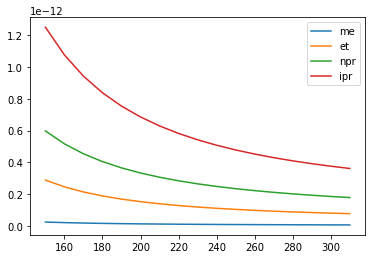

In [16]:
plt.plot(temp_range, meoo_no, label="me")
plt.plot(temp_range, etoo_no, label="et")
plt.plot(temp_range, nproo_no, label="npr")
plt.plot(temp_range, iproo_no, label="ipr")
plt.legend()

In [ ]:
sec2days = 24 * 60 * 60

In [ ]:
P = 1e5  # [Pa]
T = 273  # [K]

vmr_oh = 0.1 * 1e-12
vmr_no = 10 * 1e-12
vmr_hono = 0.5 * 1e-9

In [6]:
# Pressure and temperature range
pres_range = np.arange(250, 1e5, 500)  # [Pa]
temp_range = np.arange(150, 320, 10)  # [K]
nd_oh_range = [1e5, 1e6, 1e7]

In [ ]:
tau_hono = np.empty((len(nd_oh_range), len(pres_range), len(temp_range)))

for i, T in enumerate(temp_range):
    for j, P in enumerate(pres_range):
        for k, nd_oh in enumerate(nd_oh_range):
            M = calc_air_number_density(P, T)

            tau_hono_hv = 1 / k_hono_hv
            tau_oh_hono = 1 / (k_oh_hono(T) * nd_oh)

            tau_hono[k, j, i] = ((1 / tau_hono_hv) + (1 / tau_oh_hono) ** -1) / sec2days

In [ ]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12, 4),
    facecolor="white",
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

common_min = np.min([tau_hono[0, ...].min(), tau_hono[1, ...].min(), tau_hono[2, ...].min()])
common_max = np.max([tau_hono[0, ...].max(), tau_hono[1, ...].max(), tau_hono[2, ...].max()])
print(common_min, common_max)

logdata = True
if logdata:
    kwargs = {"norm": colors.LogNorm(vmin=common_min, vmax=common_max), "shading": "auto"}
else:
    kwargs = {"vmin": common_min, "vmax": common_max, "shading": "auto"}

p0 = axes[0].pcolormesh(temp_range, pres_range, tau_hono[0, ...], **kwargs)
p1 = axes[1].pcolormesh(temp_range, pres_range, tau_hono[1, ...], **kwargs)
p2 = axes[2].pcolormesh(temp_range, pres_range, tau_hono[2, ...], **kwargs)

axes[0].contour(temp_range, pres_range, tau_hono[0, ...], levels=[30, 45, 60, 80], colors="k")
axes[1].contour(temp_range, pres_range, tau_hono[1, ...], levels=[2.5, 7], colors="k")
axes[2].contour(temp_range, pres_range, tau_hono[2, ...], levels=[0.25, 0.7], colors="k")

fig.colorbar(p0, ax=axes, orientation="vertical", label="$\\tau_{HONO}$ [days]")

axes[0].set_title("$k_{HONO+hv}$=$10^{-3}$ [$s^{-1}]$\nOH=$10^5$ [$cm^{-3}$]")
axes[1].set_title("$k_{HONO+hv}$=$10^{-3}$ [$s^{-1}]$\nOH=$10^6$ [$cm^{-3}$]")
axes[2].set_title("$k_{HONO+hv}$=$10^{-3}$ [$s^{-1}]$\nOH=$10^7$ [$cm^{-3}$]")
axes[0].set_ylabel("Pressure [Pa]")  # if ax.get_subplotspec().is_first_col():

for ax in axes.flatten():
    ax.set_xlabel(u"Temperature [K]")
    ax.set_yscale("log")
    ax.set_ylim(1e5, 250)
    ax.axvline(x=273, color="w")
    ax.axhline(y=23800, color="w")  # 10 km

In [ ]:
tau_hono[1, ...].min(), tau_hono[1, ...].max(),

In [ ]:
((1 / 10) + (1 / 503) ** -1)

In [ ]:
(1 / (10 + 503)) ** -1